# 0 Libraries and settings

Import the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import os
import seaborn as sns
from tqdm import tqdm
import math as m
from scipy.interpolate import UnivariateSpline
from matplotlib.ticker import ScalarFormatter

Set the background color of figures to white as default when saving:

In [2]:
plt.rcParams['savefig.facecolor']='white'

# 1 Sampling from large particle dataset

## 1.1 Read in and prepare the data

Read in the particle data stored as csv file (e.g. as output of ImageJ-ParticleSizer analysis) and save them as Pandas dataframe.

In case of a single csv file:

In [3]:
frame = pd.read_csv('data\ParticleSizer_data.csv')
print (frame)

              Frame  Label       X       Y    Area  Area Conv. Hull   Peri.  \
0          1      1      1  2.3694  0.0134  0.0001           0.0001  0.0384   
1          2      1      2  0.5286  0.0149  0.0002           0.0002  0.0493   
2          3      1      3  0.6986  0.0175  0.0002           0.0003  0.0551   
3          4      1      4  2.0906  0.0200  0.0003           0.0003  0.0596   
4          5      1      5  0.8212  0.0220  0.0004           0.0004  0.0680   
...      ...    ...    ...     ...     ...     ...              ...     ...   
11648  11649     10   1341  2.3250  2.4173  0.0002           0.0002  0.0479   
11649  11650     10   1342  0.4628  2.4292  0.0002           0.0002  0.0503   
11650  11651     10   1343  1.0229  2.4302  0.0002           0.0002  0.0468   
11651  11652     10   1344  2.3205  2.4322  0.0002           0.0002  0.0530   
11652  11653     10   1345  0.1563  2.4352  0.0003           0.0003  0.0599   

       Peri. Conv. Hull   Feret  ...    Circ.  Elon

In case you want to combine data from multiple csv files:

In [ ]:
frame = pd.DataFrame()
list_ = []
os.chdir('data')
for csvFilename in os.listdir(os.getcwd()):
    if not csvFilename.endswith('.csv'):
        continue
    df = pd.read_csv(csvFilename)
    list_.append(df)
frame = pd.concat(list_)
print (frame)

Let's clean the dataframe by deleting rows which contain unreadable/uninterpretable data, i.e. NaNs (not a number) or infinity values:

In [12]:
frame.replace([np.inf, -np.inf], np.nan, inplace=True)
frame = frame.dropna()

The dataframe contains many columns with data for a variety of particle parameters that were outputted by the ParticleSizer software. In this example, we are only interested in the data of the following parameters: minimum and maximum Feret diameter (Fmin, Fmax), area equivalent circle diameter (ECD), maximum inscribed circle diameter (MICD) and aspect ratio (AR). Unify the column names of interest and create a new dataframe keeping only those columns:

In [13]:
frame.rename(columns={'Min. Feret': 'Fmin'}, inplace=True)
frame.rename(columns={'Feret': 'Fmax'}, inplace=True)
frame.rename(columns={'Area equivalent circle diameter': 'ECD'}, inplace=True)
frame.rename(columns={'Maximum inscribed circle diameter': 'MICD'}, inplace=True)
frame.rename(columns={'Aspect Ratio': 'AR'}, inplace=True)

In [14]:
columns_to_keep = ['Fmin', 'Fmax', 'ECD', 'MICD', 'AR']  
frame=frame[columns_to_keep]

We want to output the data in unit of nanometer. In case the data was in a different unit (e.g. micrometer) convert the columns of interest to nanometer (e.g. x1000).

In [15]:
frame['Fmin'] = frame['Fmin'].multiply(1000)
frame['Fmax'] = frame['Fmax'].multiply(1000)
frame['ECD'] = frame['ECD'].multiply(1000)
frame['MICD'] = frame['MICD'].multiply(1000)

## 1.2 Full dataset statistics + histogram

Let's first create a folder to output all our data. Let's call it MyMaterial_Output. 

In [20]:
os.chdir('..')
folder = 'MyMaterial_NumPar'
os.makedirs(folder) # comment this line when the folder already exists
os.chdir(folder)

Calculate the statistics of the Fmin, Fmax, ECD, MICD and AR measurands using the pandas describe function. Include also the calculation of the interquartile range (IQR) and the normalized IQR (IQR% = IQR/D50) and write them to a file:

In [21]:
def calculate_statistics(df, output_file):
    # Specify the percentiles to be calculated
    percentiles = [0.10, 0.25, 0.50, 0.75, 0.90]
    
    # Use describe to get statistics including specified percentiles
    desc = df.describe(percentiles=percentiles).T
    
    # Calculate IQR (Interquartile Range)
    desc['IQR'] = desc['75%'] - desc['25%']
    
    # Calculate IQR%
    desc['IQR%'] = desc['IQR'] / desc['50%'] * 100
    
    # Re-arrange the DataFrame to include IQR and IQR% in the output
    stats_df = desc[['count', 'mean', 'std', 'min', '10%', '25%', '50%', '75%', '90%', 'max', 'IQR', 'IQR%']]
    
    # Transpose so that statistical measures are rows and columns are original DataFrame columns
    stats_df = stats_df.T
    
    # Write the result to a CSV file
    stats_df.to_csv(output_file)

In [22]:
calculate_statistics(frame, 'Full_set_statistics.csv')

Set the measurand + unit you want to plot the histogram for:

In [23]:
measurand = 'Fmin'
unit = '(nm)'

Define the function to plot the histogram. The function contains a boolean 'PercentileLines' to determine whether vertical lines at the positions of the D10, D25, D50, D75, D90 should be drawn on the histogram. 

In [24]:
def plotHistogram(df, PercentileLines: bool):
    
    hist = sns.histplot(df, label='N = ' + str(len(df.index)), bins = 'fd') # bins according to Freedman-Diaconis rule
    
    # if PercentileLines is True, the next few lines of code will plot vertical lines on the histogram at the position of the different percentiles
    if PercentileLines:
        perc_txt = ['D10', 'D25', 'D50', 'D75', 'D90']
        percs = [df.quantile(0.1), df.quantile(0.25), df.quantile(0.5), df.quantile(0.75), df.quantile(0.9)]
        max_y_value = max([p.get_height() for p in hist.patches])
        for i, p in enumerate(percs):
            plt.axvline(x = p, color = 'k', linestyle = '--')
            plt.text(p - (percs[0]/10), max_y_value - (max_y_value/8), perc_txt[i], rotation = 'vertical', fontsize = 14)
    
    # plot settings       
    plt.xlabel(measurand + ' ' + unit, fontsize = 20)
    plt.ylabel('Count', fontsize=20)
    #plt.xlim(0,35)
    #plt.ylim(0,500)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=14)
    plt.tight_layout()
    
    # save the histogram as a figure
    plt.savefig(measurand + '_hist_N=' + str(len(df.index)) +'.png', dpi = 200)
    

Plot the histogram of Fmin:

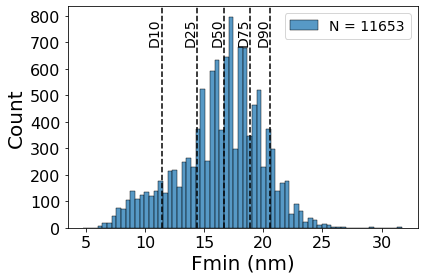

In [25]:
plotHistogram(frame[measurand], True)

## 1.3 Sampling subdatasets of increasing particle size N

Create a list of N values between 10 and the max of the full data set. For each of these values of N a subdataset will be sampled later.

In [26]:
# Create a list of 80 integers logaritmically spaced between 10 and 10^4
n=np.logspace(1, 4, num=80, dtype='int')

# In case the size of the dataset (N_tot) is smaller than 10^4, N values which are larger N_tot are removed. The N_tot value is added as the max N for sampling.
n=n[n< len(frame)]
if(n[-1]<10000): n=np.append(n, len(frame))
    
# Delete repeating numbers
n=np.unique(n)

In [27]:
print(n)

[   10    11    12    14    15    16    18    20    21    23    26    28
    31    34    37    40    44    48    52    57    62    68    74    81
    88    97   106   115   126   137   150   164   179   195   213   232
   254   277   302   330   360   393   429   468   511   558   609   664
   725   792   864   943  1029  1123  1226  1338  1460  1594  1739  1898
  2072  2261  2468  2693  2940  3208  3501  3821  4171  4552  4968  5422
  5917  6458  7048  7692  8395  9162 10000]


Construct a function to create subsamples of measured particles of increasing size N for a chosen number of samples per N. Particles are drawn with replacement, meaning each particle can be drawn more than once. In this way, multiple samples up to size N_tot can be drawn without creating identical samples. The function returns a set of dataframes (a dataframe for each measurand) where for each N the mean, standard deviation (std) and U_N is calculated. U_N is defined as the relative std (=std/mean) at a confidence interval of 95% (k=2) and given as a percentage value: U_N = 2 * 100 * std/mean.

In [28]:
def SubSampling(df, numSamplesPerNumParticles: int):
    
    # create an empty numpy array of objects with size equal to the number of columns in the dataframe, i.e. the number of measurands
    measurands = df.columns.values
    print(measurands)
    stats = np.empty(len(measurands), dtype=object)
    
    # loop over the N values
    for i in tqdm(n):    # tqdm shows a status bar for the for loop in the console + time estimate
        
        # loop over the number of subsamples
        for j in range(0, numSamplesPerNumParticles):
            # take a sample of size N with replacement
            df_s = df.sample(n=i, replace=True)
            
            #loop over the different measurands
            for k,m in enumerate(measurands):
                # calculate the statistics including percentiles of the subsample
                stats_temp = df_s[m].describe(percentiles=[0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 0.95])
                
                # Add the statistics calculated for each N and for each sample to a dataframe
                stats[k] = pd.concat([stats[k], stats_temp.to_frame().transpose()], ignore_index=True)
    
    # calculate the dataframes grouped by "count"(=particle number N), where the mean, std and U_N (saved as <lambda_0>) of the different samples at each N are calculated and store them in a list 
    data_out = []
    for s in range(0, len(stats)):
        data_out.append(stats[s].groupby("count").agg([np.mean, np.std, lambda x: 2*100* (np.std(x) / np.mean(x))]))
        
    return data_out

Run the function for 500 subsamples.

In [29]:
SamplingData = SubSampling(frame, 500)

['Fmin' 'Fmax' 'ECD' 'MICD' 'AR']


100%|██████████| 79/79 [06:14<00:00,  4.75s/it]


Define a function to rename the percentile columns in the sampling data:

In [30]:
def RenamePercCols(df):
    df.rename(
        columns={'5%': 'D5', '10%': 'D10', '25%': 'D25', '50%': 'D50', '75%': 'D75', '90%': 'D90', '95%': 'D95'},
        inplace=True)
    return

Apply the above generated function and save the dataframes as csv files for each measurand:

In [31]:
for i, fr in enumerate(SamplingData):
    RenamePercCols(fr)
    measurand = frame.columns[i]
    fr.to_csv('SubSampling_Stats_'+measurand+'.csv')

# 2 Plotting and fitting relation between N and U_N

The uncertainty related to particle number U_N is defined at each N by the relative std of the characteristic calculated based on the subsamples. It is expressed with a confidence interval of 95% (k=2). We will now plot the relation between N and U_N and determine the number of particles required to reach specific values of U_N by fitting the relation. Let's say we wanna do this for the Fmin.

First, let's read in the subsampling data produced in section 1.

Verify that you are in the right directory where the data is stored. If needed you can change the directory with the os.chdir() function.

In [32]:
os.getcwd()
#os.chdir('..')

'C:\\Users\\ChWo3222\\Desktop\\MyNotebooks\\NumPar\\MyMaterial_NumPar'

Read in the data as a pandas dataframe:

In [33]:
measurand = 'Fmin' # choose Fmin, Fmax, ECD, MICD, AR or other
data = pd.read_csv('SubSampling_Stats_'+measurand+'.csv', header=[0, 1], index_col=0)

Make a new folder, named according to the analyzed measurand, to save the generated output plots and change the directory to it:

In [34]:
folder = measurand + '_output'
os.makedirs(folder) # comment this line when the folder already exists
os.chdir(folder)

## 2.1 Plotting

Define a function that plots a specific column (defined by two column titles: column = D10, D50, etc..; par = mean, std, <lambda_0>) of a given dataframe.

In [35]:
def plot_datacolumn(df, column: str, par: str):
    
    # depending on the parameter 'par', set the correct label and unit for the y-axis
    if par == '<lambda_0>': 
        par_l = r'$U_{\rm N}$'
        unit = '(%)'
    elif par == 'mean':
        par_l = 'Mean'
        unit = '(nm)'
    elif par == 'std':
        par_l = 'Std'
        unit = '(nm)'
    else:
        par_l = par
        unit = ''
    
    # plot the data on a semilog plot
    plt.semilogx(df.index, df[column, par], '.', label=column)
    
    # plot settings
    plt.ylabel(par_l + ' ' + unit, fontsize=20)      
    plt.xlabel(r'$N$', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim(10,df.index[-1])
    plt.legend(fontsize = 14)
    plt.tight_layout()

Plot the mean and U_N as a function of N:

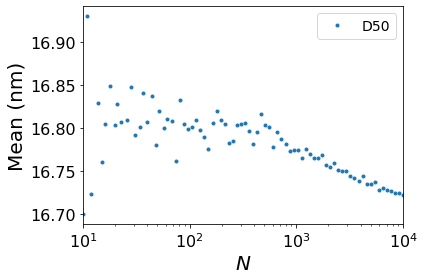

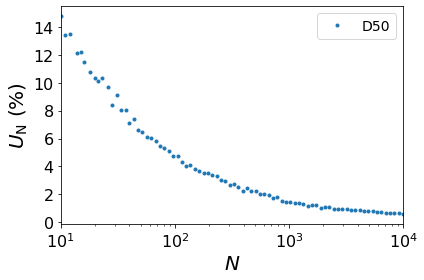

In [36]:
plot_datacolumn(data, 'D50', 'mean')
plt.show()
plot_datacolumn(data, 'D50', '<lambda_0>')
plt.show()

Plot U_N of all percentiles as a function of N on one plot:

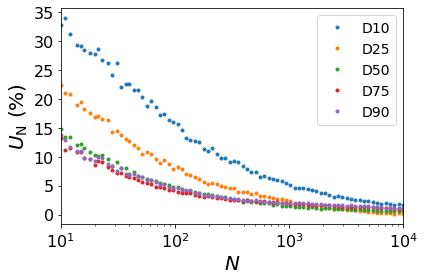

In [37]:
perc=['D10', 'D25', 'D50', 'D75', 'D90']
for p in perc:
    plot_datacolumn(data, p, '<lambda_0>')
plt.show()

Do the same but on a logscale for the y axis as well:

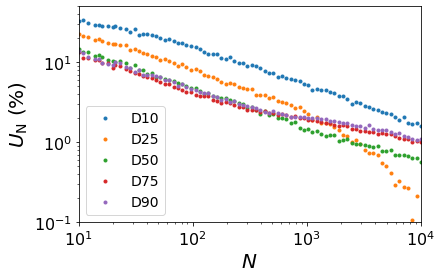

In [38]:
perc=['D10', 'D25', 'D50', 'D75', 'D90']
for p in perc:
    plot_datacolumn(data, p, '<lambda_0>')
plt.yscale('log')
plt.ylim(0.1,50)
plt.show()

## 2.2 Fitting U_N using UnivariateSpline

Set parameter for which you wanna do the fitting:

In [39]:
par = 'D50'

Create an array of x values to be used for the fitting function:

In [40]:
xs = np.linspace(1, 4, 1000)
xs_f = 10**xs
xs_f = xs_f[xs_f<=data.index[-1]]

Define a function to fit a smooth curve to the U_N vs. N data, using the UnivariateSpline function. The smoothing parameter defines the degree of smooting and this will have to be adapted manually to achieve the best fit.

In [41]:
def smoothCurve(df, column, smoothing):
    # x data need to be converted to linear scale for the spline to work
    xlogScale = np.log10(df.index)  
    
    # perform the fit using UnivariateSpline function
    s = UnivariateSpline(xlogScale, df[column, '<lambda_0>'], s = smoothing) #s = smoothing factor, the higher the more smoothing is applied
    ys = s(xs)
    ys_f = ys[0:len(xs_f)]
    
    # plot the fit function and plot the data on the same figure
    plt.plot(xs_f, ys_f, 'k-')
    plot_datacolumn(df, column, '<lambda_0>')
    
    #plot settings
    plt.xscale('log')
    plt.tight_layout()
    plt.show()
    
    #return the y values of the fit curve
    return ys_f

Perform the fitting procedure for the D50 data and adapt the smoothing value until a nice smooth curve fit is obtained. Increasing the value will make the curve more smooth.

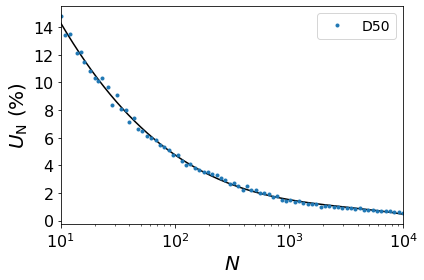

array([14.28898678, 14.2468874 , 14.20488155, 14.16296912, 14.12115001,
       14.07942409, 14.03779127, 13.99625142, 13.95480444, 13.91345021,
       13.87218863, 13.83101958, 13.78994296, 13.74895865, 13.70806654,
       13.66726652, 13.62655848, 13.5859423 , 13.54541789, 13.50498512,
       13.46464388, 13.42439407, 13.38423558, 13.34416828, 13.30419208,
       13.26430685, 13.2245125 , 13.1848089 , 13.14519595, 13.10567353,
       13.06624155, 13.02689987, 12.9876484 , 12.94848702, 12.90941562,
       12.87043409, 12.83154232, 12.7927402 , 12.75402762, 12.71540446,
       12.67687062, 12.63842598, 12.60007044, 12.56180387, 12.52362618,
       12.48553725, 12.44753697, 12.40962522, 12.37180191, 12.3340669 ,
       12.29642011, 12.25886141, 12.22139069, 12.18400784, 12.14671276,
       12.10950532, 12.07238543, 12.03535296, 11.99840781, 11.96154987,
       11.92477902, 11.88809515, 11.85149816, 11.81498793, 11.77856436,
       11.74222732, 11.70597671, 11.66981242, 11.63373434, 11.59

In [42]:
smoothing = 3
smoothCurve(data, 'D50', smoothing)

The next lines of code will do the smoothing for each of the percentiles of the chosen measurand at the same time and save the output curves in the array sC:

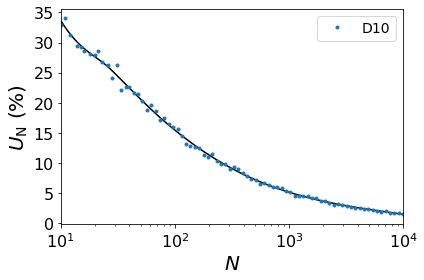

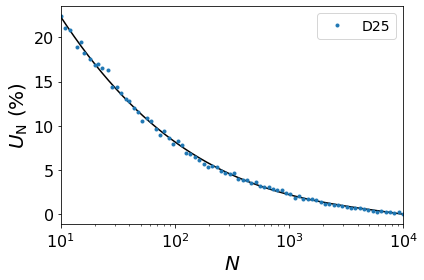

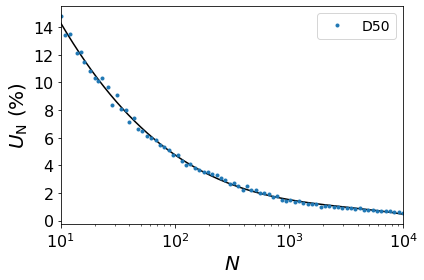

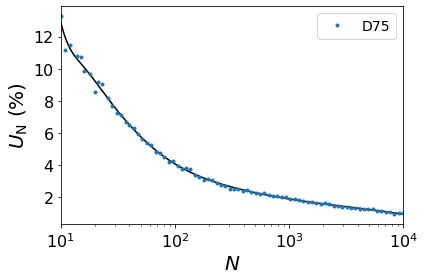

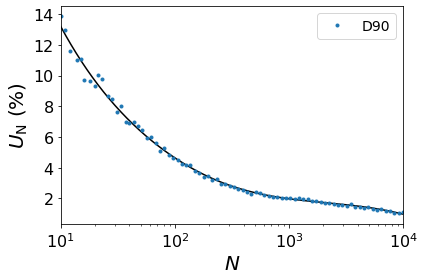

In [48]:
smo_list = [19, 8, 3, 2, 4]
perc=['D10', 'D25', 'D50', 'D75', 'D90']
sC = [0]*len(perc)

for i, p in enumerate(perc):
    sC[i] = smoothCurve(data, p, smo_list[i])

# 3 Determining N_m from the spline curve

Define the function to calculate N_m for a predefined precision (=U_N) based on the smooth spline curve:

In [49]:
def det_Nm(precision, ys):
    
    # if the required precision is already reached for less then 10 particles, return NaN
    if ys[0] < precision:
        #return 10  # return 10 instead of NaN when Nm is actually lower than 10  --> for Nm vs. IQR/d50 plot
        return np.nan
    
    # otherwise calculate at which N the curve intersects the required value of the precision
    else:
        idx = np.argwhere(np.diff(np.sign(precision - ys))).flatten()
        
        if not idx.size > 0:
            return np.nan
        else:
            idx = idx[0]
            Nm_lin=xs[idx]
            Nm=m.ceil(10**Nm_lin)
            #print(Nm)
            return Nm

Define a set of U_N values for which you want to calculate N_m and initiate a dataframe to save the N_m values:

In [50]:
UN_out=[40, 30, 20, 15, 10, 8, 6, 5, 4, 3, 2, 1]
df_Nm = pd.DataFrame()
df_Nm['U_N']=UN_out

Apply the det_Nm function for each element of the U_N array and for each of the percentiles. Save the N_m dataframe to a csv file:

In [51]:
for i, p in enumerate(perc):
    c = sC[i]
    N=[]
    for U in UN_out:
        N.append(det_Nm(U, c))
    print(N)
    df_Nm[p]=N

[nan, 15, 54, 108, 260, 413, 738, 1072, 1692, 3024, 6514, nan]
[nan, nan, 14, 27, 67, 105, 183, 257, 380, 617, 1165, 2881]
[nan, nan, nan, nan, 23, 36, 64, 91, 140, 241, 541, 2982]
[nan, nan, nan, nan, 17, 27, 47, 67, 105, 214, 830, 9078]
[nan, nan, nan, nan, 19, 31, 58, 85, 138, 266, 953, 9661]


In [52]:
df_Nm.to_csv('Nm_table_'+measurand+'.csv')

# 4 Output plot(s)

## 4.1 N_m vs U_N

Set the measurand for which you wanna produce the plot:

In [53]:
measurand = 'Fmin'

Read in the N_m data generated in section 3. If needed first go the right directory:

In [54]:
os.getcwd()
#os.chdir('..')

'C:\\Users\\ChWo3222\\Desktop\\MyNotebooks\\NumPar\\MyMaterial_NumPar\\Fmin_output'

In [55]:
plot_data = pd.read_csv('Nm_table_'+measurand+'.csv', header=[0], index_col=0)

In [56]:
plot_data

,U_N,D10,D25,D50,D75,D90
0,40,NaN,NaN,NaN,NaN,NaN
1,30,15.0,NaN,NaN,NaN,NaN
2,20,54.0,14.0,NaN,NaN,NaN
3,15,108.0,27.0,NaN,NaN,NaN
4,10,260.0,67.0,23.0,17.0,19.0
5,8,413.0,105.0,36.0,27.0,31.0
6,6,738.0,183.0,64.0,47.0,58.0
7,5,1072.0,257.0,91.0,67.0,85.0
8,4,1692.0,380.0,140.0,105.0,138.0
9,3,3024.0,617.0,241.0,214.0,266.0


Plot the N_m vs. U_N data on a log-log plot for each of the percentiles. You will see that a linear relation is obtained. Use the polyfit function to fit a first degree polynomial to the data. The relation can be used to estimate the amount of particles you should measure of your material to assure a certain precision of the measurement.

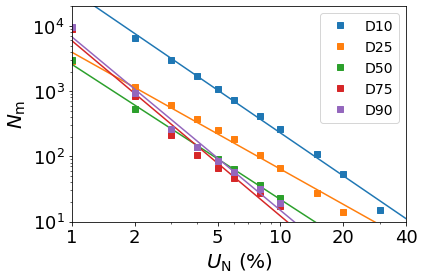

In [57]:
# extract the columns names (=percentiles) of the plot_data dataframe 
key_list = list(plot_data)
key_list.remove('U_N')

# set the x values for the polyfit and define the colors to be used for the plotting of the different percentiles
x_fit = np.arange(-1, 3)
color = ['C0', 'C1', 'C2', 'C3', 'C4']
fig, ax = plt.subplots()

# loop through the different percentiles and colors
for k, c in zip(key_list, color):
    # split the dataframe up in its columns and remove the NaN rows
    df_sub = pd.DataFrame()
    df_sub['U_N'] = plot_data['U_N']
    df_sub['Nm'] = plot_data[k]
    df_sub = df_sub.dropna()
    
    # plot the data points
    plt.plot(df_sub['U_N'], df_sub['Nm'], ls='None', marker ='s', color=c, label=k)
    
    # perform the linear fit using polyfit
    if len(df_sub)>1:
        z = np.polyfit(np.log10(df_sub['U_N']), np.log10(df_sub['Nm']), 1)
        p = np.poly1d(z)
        plt.plot(10.0**(x_fit), 10.0**(p(x_fit)), '-', color=c)
        

# plot settings        
plt.xlabel(r'$U_{\rm N}$ ($\%$)', fontsize=20)
plt.ylabel(r'$N_{\rm m}$', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,40)
plt.ylim(10,2*10**4)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks([1,2,5,10, 20, 40])
plt.legend(fontsize = 14)
plt.tight_layout()

# save the figure
plt.savefig('NumPar_vs_UN_'+measurand+'.png', dpi=200)
